## Elasticsearch performance tests

This is a simple notebook which evaluates time performance of elasticsearch requests using different document sizes and different requests. The following tests were run creating indexes and indexing data with sizes of 10K, 20K, 30K, 50K and 100K documents:
- Basic query "match_all" without filters.
- Geo shape filtered query.
- Geo shape filtered query with heatmap facetting.
- "match_all" query with heatmap facetting.

Tested with Elasticsearch 5.1.1 with heatmap plugin installed:
https://github.com/boundlessgeo/elasticsearch-heatmap/

## Functions definitions.

In [31]:
# Create elasticsearch connection.
import rawes
es = rawes.Elastic('http://localhost:9200')
global_query = {
    "query": {
        "match_all": {}
    }
}
geoshape_filter = {
  "bool": {
    "filter": {
      "geo_shape": {
        "layer_geoshape": {
          "shape": {
            "type": "envelope", 
            "coordinates": [
              ["-180.0", "90.0"], 
              ["180.0", "-90.0"]
            ]
          }, 
          "relation": "intersects"
        }
      }
    }
  }
}
heatmap_agg = {
  "viewport": {
    "heatmap": {
      "dist_err_pct": 0.07, 
      "field": "layer_geoshape", 
      "geom": {
        "geo_shape": {
          "layer_geoshape": {
            "shape": {
              "type": "envelope", 
              "coordinates": [
                ["-180.0", "90.0"], 
                ["180.0", "-90.0"]
              ]
            }, 
            "relation": "within"
          }
        }
      }
    }
  }
}

def p_hr():
    print "==============================================================="

def l_hr():
    print "---------------------------------------------------------------"    

In [32]:
def basic_query(index_name):
    query = global_query.copy()
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [33]:
def filtered_geoshape_query(index_name):
    query = global_query.copy()
    query['query'] = geoshape_filter
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [34]:
def heatmap_aggregation(index_name):    
    query = global_query.copy()
    query['query'] = geoshape_filter
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [35]:
def heatmap_aggregation_nofilter(index_name):    
    query = global_query.copy()
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [36]:
def test_performance(index_name):
    time_list = []
    p_hr()
    print "Test performance for %s" % (index_name)
    p_hr()
    
    print "\nBasic Query"
    l_hr()
    response = basic_query(index_name)
    print 'Total number of records: %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])    

    print "Geoshape filtering query"
    l_hr()
    response = filtered_geoshape_query(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took']) 

    print "Heatmap aggregation query"
    l_hr()
    response = heatmap_aggregation(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])

    print "Heatmap aggregation without filter query"
    l_hr()
    response = heatmap_aggregation_nofilter(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs' % response['took']
    time_list.append(response['took'])
    
    return time_list

### 1. Experiments with 10k documents

#### a. Create and index documents with mapping...using bash

In [37]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_10k -d @mapping.json
print '\nIndexing documents...'
!time curl --silent -XPOST http://localhost:9200/index_10k/layer/_bulk --data-binary @data_es/scroll_0001.json > /dev/null
times_10k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m14.072s
user	0m0.015s
sys	0m0.054s


{u'_shards': {u'failed': 0, u'successful': 5, u'total': 10}}

#### b. Test performance

In [38]:
time_10k = test_performance('index_10k')

Test performance for index_10k

Basic Query
---------------------------------------------------------------
Total number of records: 10000
Response time 133 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 10000
Response time 66 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 10000
Response time 186 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 10000
Response time 65 msecs


### 2. Experiments with 20k documents

#### a. Create and index documents with mapping...using bash

In [39]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_20k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 2 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_20k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_20k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m20.355s
user	0m0.034s
sys	0m0.116s


{u'_shards': {u'failed': 0, u'successful': 10, u'total': 20}}

#### b. Test performance

In [40]:
time_20k = test_performance('index_20k')

Test performance for index_20k

Basic Query
---------------------------------------------------------------
Total number of records: 20000
Response time 24 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 20000
Response time 48 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 20000
Response time 94 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 20000
Response time 90 msecs


### 3. Experiments with 30k documents

#### a. Create and index documents with mapping...using bash

In [41]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_30k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 3 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_30k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_30k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m30.178s
user	0m0.048s
sys	0m0.171s


{u'_shards': {u'failed': 0, u'successful': 15, u'total': 30}}

#### b. Test performance

In [42]:
time_30k = test_performance('index_30k')

Test performance for index_30k

Basic Query
---------------------------------------------------------------
Total number of records: 30000
Response time 21 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 30000
Response time 30 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 30000
Response time 93 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 30000
Response time 73 msecs


### 4. Experiments with 50k documents

#### a. Create and index documents with mapping...using bash

In [43]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_50k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 5 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_50k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_50k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m43.208s
user	0m0.080s
sys	0m0.291s


{u'_shards': {u'failed': 0, u'successful': 20, u'total': 40}}

#### b. Test performance

In [44]:
time_50k = test_performance('index_50k')

Test performance for index_50k

Basic Query
---------------------------------------------------------------
Total number of records: 50000
Response time 20 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 50000
Response time 109 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 50000
Response time 579 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 50000
Response time 112 msecs


### 5. Experiments with 100k documents

#### a. Create and index documents with mapping...using bash

In [45]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_100k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 10 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_100k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_100k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	1m28.551s
user	0m0.150s
sys	0m0.551s


{u'_shards': {u'failed': 0, u'successful': 25, u'total': 50}}

#### b. Test performance

In [46]:
time_100k = test_performance('index_100k')

Test performance for index_100k

Basic Query
---------------------------------------------------------------
Total number of records: 100000
Response time 95 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 100000
Response time 260 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 100000
Response time 2935 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 100000
Response time 101 msecs


Populating the interactive namespace from numpy and matplotlib


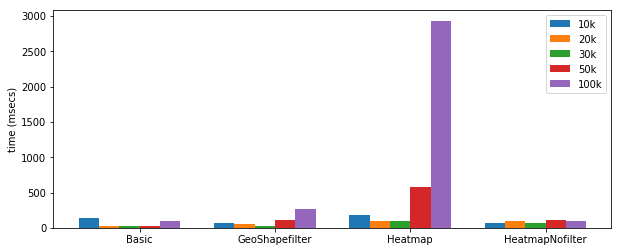

In [47]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

import numpy as np
from matplotlib import pyplot as plt

N = 4
ind = np.arange(N)
width = 0.15
fig, ax = plt.subplots()
rects_10k = ax.bar(ind, time_10k, width)
rects_20k = ax.bar(ind + width, time_20k, width)
rects_30k = ax.bar(ind + 2*width, time_30k, width)
rects_50k = ax.bar(ind + 3*width, time_50k, width)
rects_100k = ax.bar(ind + 4*width, time_100k, width)

ax.set_ylabel('time (msecs)')
ax.set_xticks(ind + 2.5*width)
ax.set_xticklabels(('Basic', 'GeoShapefilter', 'Heatmap', 'HeatmapNofilter'))

legend_tuple = (rects_10k[0], rects_20k[0], rects_30k[0], rects_50k[0], rects_100k[0])
legend_names = ('10k', '20k', '30k', '50k', '100k')
ax.legend(legend_tuple, legend_names)


plt.show()